## Import packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
import keras
import os
import numpy as np
import json
# import kerastuner as kt
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0

Python 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]
Pandas 1.4.4
Scikit-Learn 1.1.2
GPU is available


## Load data

In [3]:
def str2float(s):
    f_list = [float(idx) for idx in s.split(',')]
    return f_list
    

In [4]:
train_df = pd.read_csv("train.csv")
# x_train_raw = np.array([str2float(data) for data in train_df['heartbeat_signals']], dtype=np.float32)
x_train_raw = np.array([str2float(data) for data in train_df['heartbeat_signals']], dtype=np.float32)[0:99000]
# y_train = np.array(train_df['label'].values, dtype=int)
y_train = np.array(train_df['label'].values, dtype=int)[0:99000]

In [5]:
# test_df = pd.read_csv("test.csv")
# x_test_raw = np.array([str2float(data) for data in test_df['heartbeat_signals']], dtype=np.float32)
x_test_raw = np.array([str2float(data) for data in train_df['heartbeat_signals']], dtype=np.float32)[99000:100000]
# y_test = np.array(test_df['label'].values, dtype=int)
y_test = np.array(train_df['label'].values, dtype=int)[99000:100000]
# No labels found in 'test.csv', so a portion of the test dataest is used for validation.

In [6]:
VOCAB_SIZE = 256        #ECG Graph res

MAXLEN = 205            # length of a single ECG data string
BATCH_SIZE = 8

### Data normalization

In [7]:
def normalize(data, MAX, MIN, scale):
    return scale*(data-MIN)/(MAX-MIN)

In [8]:
x_train = np.array([normalize(data, max(data), min(data), 255) for data in x_train_raw], dtype=int)

In [9]:
x_test = np.array([normalize(data, max(data), min(data), 255) for data in x_test_raw],dtype=int)

# ML

## Build model

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [11]:
def build_LSTM():
    input_shape = (10, 400)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE, 32),      # This will tell keras to creat a vocab vector space of 32 dimension (outputs) and vocab_amount(vetors) as "VOCAB_SIZE" 
        # tf.keras.layers.LSTM(32, return_sequences=True),                       
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation="relu")  
    ])
    return model

def build_Transformer():
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(MAXLEN,))
    embedding_layer = TokenAndPositionEmbedding(MAXLEN, VOCAB_SIZE, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    outputs = transformer_block(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



def build_Dense():
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=(10,)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu')
    ])
    return model

### Learning Schedule

In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [13]:
learning_rate = CustomSchedule(32)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Metal device set to: Apple M1


2022-10-22 21:01:47.049279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-22 21:01:47.049398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Text(0.5, 0, 'Train Step')

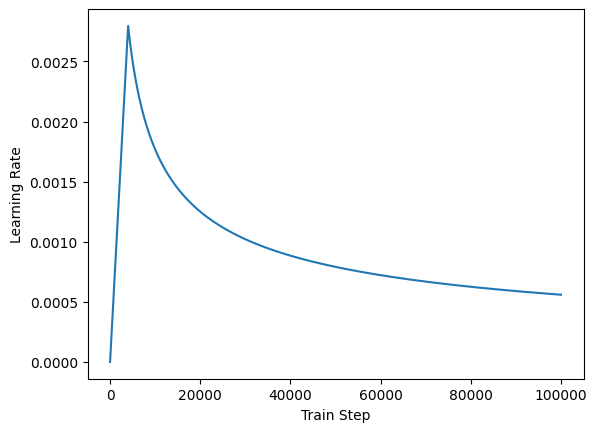

In [14]:
plt.plot(learning_rate(tf.range(100000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Train

In [15]:
rnn = build_Transformer()

In [16]:
rnn_classifier1 = tf.keras.layers.concatenate([rnn.output])
x = layers.GlobalAveragePooling1D()(rnn_classifier1)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(4, activation="relu")(x)
model = tf.keras.Model(inputs=rnn.input, outputs=x)

In [17]:
# Same architecture as the model in the root directory.
model.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(
                    x=x_train, y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=50, batch_size=32,
                   )


Epoch 1/50


2022-10-22 21:01:47.478949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-22 21:01:47.958191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3094/3094 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7879

2022-10-22 21:05:00.523959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3094/3094 [==============================] - 194s 62ms/step - loss: 0.6189 - accuracy: 0.7879 - val_loss: 0.3939 - val_accuracy: 0.8820
Epoch 2/50
3094/3094 [==============================] - 202s 65ms/step - loss: 0.2938 - accuracy: 0.9097 - val_loss: 0.2081 - val_accuracy: 0.9340
Epoch 3/50
3094/3094 [==============================] - 205s 66ms/step - loss: 0.1977 - accuracy: 0.9408 - val_loss: 0.1437 - val_accuracy: 0.9540
Epoch 4/50
3094/3094 [==============================] - 208s 67ms/step - loss: 0.1614 - accuracy: 0.9514 - val_loss: 0.1349 - val_accuracy: 0.9600
Epoch 5/50
 233/3094 [=>............................] - ETA: 3:10 - loss: 0.1307 - accuracy: 0.9591

KeyboardInterrupt: 